In [1]:
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install --quiet transformers
! pip install --quiet tensorflow-addons
! pip install --quiet texthero

     |████████████████████████████████| 2.9 MB 10.9 MB/s 
     |████████████████████████████████| 636 kB 46.4 MB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
     |████████████████████████████████| 1.1 MB 13.4 MB/s 
     |████████████████████████████████| 235 kB 17.1 MB/s 
     |████████████████████████████████| 1.5 MB 52.6 MB/s 


In [3]:
%cd /content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ

/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ


In [4]:
import os

In [5]:
DRIVE_PATH = '/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ'

In [6]:
import logging
import datetime
import warnings

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import fbeta_score
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.optimize import minimize, minimize_scalar

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

import torch
from lightgbm import LGBMModel

import texthero as hero
import transformers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
INPUT = os.path.join(DRIVE_PATH, "input")
OUTPUT = os.path.join(DRIVE_PATH, "output")
OUTPUT_EXP = os.path.join(OUTPUT, "file")
OUTPUT_EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
OUTPUT_EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")
OUTPUT_EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
OUTPUT_EXP_FEATS = os.path.join(OUTPUT_EXP, "features")

SUBMISSION = os.path.join(DRIVE_PATH, "submission")

if not os.path.isdir(INPUT):  # 初回時にのみデータをINPUTフォルダにロード
    os.makedirs(INPUT, exist_ok=True)

dirs = [INPUT, OUTPUT, OUTPUT_EXP, SUBMISSION, OUTPUT_EXP_MODEL, OUTPUT_EXP_PREDS, OUTPUT_EXP_FIG, OUTPUT_EXP_FEATS]
for d in dirs:
    os.makedirs(d, exist_ok=True)

In [8]:
class Config:
    name_v1 = "lgb"

    model_params = dict(n_estimators=10000,
                        num_leaves=31,
                        objective="binary", 
                        learning_rate=0.01,
                        colsample_bytree=0.3, 
                        class_weight="balanced",
                        importance_type="gain")
    
    fit_params = dict(early_stopping_rounds=100, 
                      verbose=100)
    
    n_fold = 5 
    seeds = [2021]
    target_col = "judgement"
    submit = True
    debug = False

In [9]:
class Logger:
    """log を残す用のクラス"""
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [10]:
class Util:
    """pkl保存&load"""
    @classmethod
    def dump(cls, value, path):
        joblib.dump(value, path, compress=True)

    @classmethod
    def load(cls, path):
        return joblib.load(path)

In [11]:
warnings.filterwarnings("ignore")  # ignore warnings
logger = Logger(OUTPUT_EXP)

In [12]:
class AutoSequenceVectorizer:
    """
    事前学習済み BERT モデルを使ったテキスト特徴抽出
    https://www.guruguru.science/competitions/16/discussions/fb792c87-6bad-445d-aa34-b4118fc378c1/
    kaerururuさんのこちらのディスカッションを参考にさせて頂きました．
    """
    def __init__(self, model_name='bert-base-uncased', max_len=128):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.model_name)
        self.model = transformers.AutoModel.from_pretrained(self.model_name)
        self.model = self.model.to(self.device)
        self.max_len = max_len

    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        output = self.model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = output['last_hidden_state'], output['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()


In [13]:
def basic_text_features_transforme(input_df, text_columns, cleansing_hero=None, name=""):
    """basic な text 特徴量"""
    def _get_features(dataframe, column):
        _df = pd.DataFrame()
        _df[column + name + '_num_chars'] = dataframe[column].apply(len)
        _df[column + name + '_num_exclamation_marks'] = dataframe[column].apply(lambda x: x.count('!'))
        _df[column + name + '_num_question_marks'] = dataframe[column].apply(lambda x: x.count('?'))
        _df[column + name + '_num_punctuation'] = dataframe[column].apply(lambda x: sum(x.count(w) for w in '.,;:'))
        _df[column + name + '_num_symbols'] = dataframe[column].apply(lambda x: sum(x.count(w) for w in '*&$%'))
        _df[column + name + '_num_words'] = dataframe[column].apply(lambda x: len(x.split()))
        _df[column + name + '_num_unique_words'] = dataframe[column].apply(lambda x: len(set(w for w in x.split())))
        _df[column + name + '_words_vs_unique'] = _df[column + name + '_num_unique_words'] / _df[column + name + '_num_words']
        _df[column + name + '_words_vs_chars'] = _df[column + name + '_num_words'] / _df[column + name + '_num_chars']
        return _df

    output_df_ = pd.DataFrame()
    output_df_[text_columns] = input_df[text_columns].fillna('missing').astype(str)
    output_lst = []
    for c in text_columns:
        if cleansing_hero is not None:
            output_df_[c] = cleansing_hero(output_df_, c)
        output_df = _get_features(output_df_, c)
        output_lst.append(output_df)
    output_df = pd.concat(output_lst, axis=1)
    return output_df

In [14]:
def vectorize_text(input_df, 
                   text_columns,
                   cleansing_hero=None,
                   vectorizer=CountVectorizer(),
                   transformer=TruncatedSVD(n_components=128),
                   name='html_count_svd'):
    """countベースのtext特徴量"""
    
    output_df = pd.DataFrame()
    output_df[text_columns] = input_df[text_columns].fillna('missing').astype(str)
    features = []
    for c in text_columns:
        if cleansing_hero is not None:
            output_df[c] = cleansing_hero(output_df, c)

        sentence = vectorizer.fit_transform(output_df[c])
        feature = transformer.fit_transform(sentence)
        num_p = feature.shape[1]
        feature = pd.DataFrame(feature, columns=[name+str(num_p) + f'={i:03}' for i in range(num_p)])
        features.append(feature)
    output_df = pd.concat(features, axis=1)
    return output_df

In [15]:
def cleansing_hero_only_text(input_df, text_col):
    ## get text only 
    custom_pipeline = [
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        hero.preprocessing.remove_stopwords,
        hero.preprocessing.remove_whitespace,
        hero.preprocessing.stem
    ]
    texts = hero.clean(input_df[text_col], custom_pipeline)
    return texts

In [16]:
def get_basic_text_features(input_df):
    output_df = basic_text_features_transforme(input_df, 
                                               text_columns=["title", "abstract"],
                                               cleansing_hero=cleansing_hero_only_text)
    return output_df


In [17]:
def get_tfidf_features__svd64(input_df):
    output_df = vectorize_text(input_df,
                               text_columns=["title", "abstract"],
                               cleansing_hero=cleansing_hero_only_text,
                               vectorizer=TfidfVectorizer(min_df=0.001, max_df=0.99),
                               transformer=TruncatedSVD(n_components=64),
                               name="tfidf_svd_")
    return output_df

In [18]:
def get_count_features__svd64(input_df):
    output_df = vectorize_text(input_df, 
                               text_columns=["title", "abstract"],
                               cleansing_hero=cleansing_hero_only_text,
                               vectorizer=CountVectorizer(min_df=0.001, max_df=0.99),
                               transformer=TruncatedSVD(n_components=64),
                               name="count_svd_")
    return output_df

In [19]:
def get_scibert_features__pca128(input_df):
    """scibertで特徴抽出"""
    vectorizer = AutoSequenceVectorizer(model_name="allenai/scibert_scivocab_uncased", 
                                        max_len=256)
    texts = input_df["title"] + " " + input_df["abstract"].fillna("")
    text_vecs = np.array([vectorizer.vectorize(x) for x in tqdm(texts)])
    pca = PCA(n_components=128)
    text_vecs = pca.fit_transform(text_vecs)

    output_df = pd.DataFrame(text_vecs, columns=[f"scibert_pca_vecs={i:03}" for i in range(text_vecs.shape[1])])
    return output_df

In [20]:
def get_fasttext_features(input_df):
  sentences = []
  texts = input_df["title"] + " " + input_df["abstract"].fillna("")
  for review in tqdm(texts):
    try:
        # Split a review into parsed sentences.
        result = review
        h = result.split(" ")
        h = list(filter(("").__ne__, h))
        sentences.append(h)
    except:
        continue

  num_features = 128
  model=FastText(sentences,size=num_features)
  model_name = str(num_features) + "_features"
  model.init_sims(replace=True)
  
  tqdm.pandas()

  def des_to_mean_vec(text):
      
      try:
          text = text.strip()
          text_ls = [s for s in text.split(' ') if '' != s]
          return np.mean([model.wv[word] for word in text_ls if word in model.wv.index2word], axis=0)
      except:
          return np.nan

  df = texts.progress_apply(lambda x: des_to_mean_vec(x))
  output = df.apply(pd.Series)
  output.columns = ['fasttext_' + str(col) for col in output.columns]
  return output

In [21]:
def get_word2vec_features(input_df):
  sentences = []
  texts = input_df["title"] + " " + input_df["abstract"].fillna("")
  for review in tqdm(texts):
    try:
        # Split a review into parsed sentences.
        result = review
        h = result.split(" ")
        h = list(filter(("").__ne__, h))
        sentences.append(h)
    except:
        continue

  num_features = 128
  model=Word2Vec(sentences,size=num_features)
  model_name = str(num_features) + "_features"
  model.init_sims(replace=True)
  tqdm.pandas()

  def des_to_mean_vec(text):
    try:
      text = text.strip()
      text_ls = [s for s in text.split(' ') if '' != s]
      return np.mean([model.wv[word] for word in text_ls if word in model.wv.index2word],axis=0)
    except:
      return np.nan

  df = texts.progress_apply(lambda x: des_to_mean_vec(x))
  output = pd.DataFrame()
  for num in tqdm(list(range(0,68000,1000))):
    output = pd.concat([output,df.iloc[num:num+1000].apply(pd.Series)])
  output.columns = ['w2v_' + str(col) for col in output.columns]  
  return output

In [22]:
def preprocess(train, test):
    """前処理の実行関数"""
    input_df = pd.concat([train, test]).reset_index(drop=True)
    funcs = [get_basic_text_features,
             get_scibert_features__pca128,
             get_tfidf_features__svd64, 
             get_count_features__svd64,
             get_fasttext_features,
             get_word2vec_features
             ]

    output = []
    for func in funcs:
        filepath = os.path.join(OUTPUT_EXP_FEATS, f"{func.__name__}.pkl")
        if os.path.isfile(filepath):
            _df = Util.load(filepath)
        else:
            _df = func(input_df)  # 作った特徴量は保存
            Util.dump(_df, filepath)
        output.append(_df)
    output = pd.concat(output, axis=1)

    train_x = output.iloc[:len(train)]
    train_y = train[Config.target_col]
    test_x = output.iloc[len(train):].reset_index(drop=True)

    return train_x, train_y, test_x

In [23]:
class LGBM:
    """LGBMModelのラッパー"""
    def __init__(self):
        self.model = None

    def build(self):
        self.model = LGBMModel(**Config.model_params)
    
    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y, eval_set=[(va_x, va_y)], **Config.fit_params)
    
    def predict(self, x):
        preds = self.model.predict(x)
        return preds

    def save(self, filepath):
        Util.dump(self.model, filepath)
    
    def load(self, filepath):
        self.model = Util.load(filepath)

In [24]:
def skf(train, n_splits, random_state):
    """層化KFoldのインデックスのリストを作成"""
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    return list(skf.split(train, train[Config.target_col]))

In [25]:
def opt_fbeta_threshold(y_true, y_pred):
    """fbeta score計算時のthresholdを最適化"""
    def opt_(x): 
        return -fbeta_score(y_true, y_pred >= x, beta=7)
    result = minimize_scalar(opt_, bounds=(0, 1), method='bounded') 
    best_threshold = result['x'].item()
    return best_threshold

In [26]:
def metrics(y_true, y_pred):
    """fbeta(beta=7)の閾値最適化評価関数"""
    bt = opt_fbeta_threshold(y_true, y_pred)
    print(f"bt:{bt}")
    score = fbeta_score(y_true, y_pred >= bt, beta=7)
    return score

In [27]:
def train_cv_v2(X, y, cv, metrics, name, directory):
    oof = np.zeros(len(y))
    for i_fold, (tr_idx, va_idx) in enumerate(cv):
        filepath = os.path.join(directory, f"{name}_fold{i_fold+1}.pkl")
        tr_x, va_x = X.iloc[tr_idx].reset_index(drop=True), X.iloc[va_idx].reset_index(drop=True)
        tr_y, va_y = y.values[tr_idx], y.values[va_idx]

        model = LGBM()
        model.build()
        model.fit(tr_x, tr_y, va_x, va_y)
        preds = model.predict(va_x)
        model.save(filepath)
        oof[va_idx] = preds

        score = metrics(np.array(va_y), np.array(preds))
        logger.info(f"{name}_fold{i_fold+1} >>> val socre:{score:.4f}")
    
    score = metrics(np.array(y), oof)
    logger.info(f"{name} >>> val score:{score:.4f}")
    return oof

In [28]:
def predict_cv_v2(X, name, directory):
    preds_fold = []
    for i_fold in range(Config.n_fold):
        filepath = os.path.join(directory, f"{name}_fold{i_fold+1}.pkl")
        logger.info(f"{name}_fold{i_fold+1} inference")
        model = LGBM()
        model.build()
        model.load(filepath)
        preds = model.predict(X)
        preds_fold.append(preds)
    
    preds = np.mean(preds_fold, axis=0)
    return preds

In [29]:
def tree_importance(X, y, Model, cv):
    """importance を取得"""
    feature_importance_df = pd.DataFrame()
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.values[tr_idx], X.values[va_idx]
        tr_y, va_y = y.values[tr_idx], y.values[va_idx]

        est = Model()
        est.build()

        est.fit(tr_x, tr_y, va_x, va_y) 
        _df = pd.DataFrame()
        _df['feature_importance'] = est.model.feature_importances_
        _df['column'] = X.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column') \
                .sum()[['feature_importance']] \
                .sort_values('feature_importance', ascending=False).index[:50]
    fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                  palette='viridis')
    fig.tight_layout()
    ax.grid()
    ax.set_title('feature importance')
    fig.tight_layout()
    return fig, feature_importance_df

In [30]:
def visualize_confusion_matrix(
        y_true,
        pred_label,
        height=.6,
        labels=None):
    """混合行列をプロット"""
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    plt.show()
    return fig

In [31]:
def main():
    # load data
    train = pd.read_csv(os.path.join(INPUT, "train_clean_df.csv"))
    test = pd.read_csv(os.path.join(INPUT ,"test_clean_df.csv"))

    if Config.debug:
        train = train.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)
        test = test.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)

    # preprocess
    print("# ============= # Preprocess # ============= #")
    train_x, train_y, test_x = preprocess(train, test)
    print(train_x.shape)

    # feature importace 
    print("# ============= # Importance # ============= #")
    fig, _df = tree_importance(X=train_x,
                               y=train_y, 
                               Model=LGBM,
                               cv=skf(train,
                                      n_splits=3,
                                      random_state=Config.seeds[0]))
    fig.savefig(os.path.join(OUTPUT_EXP_FIG, "importance.png"), dpi=300)

    # training
    print("# ============= # Training # ============= #")
    oof_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        oof = train_cv_v2(X=train_x, y=train_y, 
                          cv=skf(train, n_splits=Config.n_fold, random_state=seed),
                          metrics=metrics, 
                          name=name, 
                          directory=OUTPUT_EXP_MODEL)
        oof_df[name] = oof
    oof_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "oof.csv"), index=False)

    # get oof score & best threshold 
    y_true = train[Config.target_col]
    y_pred = oof_df.mean(axis=1)

    best_threshold = opt_fbeta_threshold(y_true.values, y_pred.values)
    oof_score = fbeta_score(y_true, y_pred >= best_threshold, beta=7)
    comments = f"score:{oof_score:.4f}/threshold:{best_threshold}"  # 最終的なスコアと閾値 (スペースがあるとsubmit時のコメントエラーが出る)
    logger.info(comments)

    fig = visualize_confusion_matrix(y_true, y_pred>=best_threshold)  # 混合行列を表示&save
    fig.savefig(os.path.join(OUTPUT_EXP_FIG, "cm.png"), dpi=300)

    # inference
    print("# ============= # Inference # ============= #")
    preds_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        preds = predict_cv_v2(test_x, name, directory=OUTPUT_EXP_MODEL)
        preds_df[name] = preds

    preds_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "preds.csv"), index=False)

    # submit
    if Config.submit:
        sub_df = pd.read_csv(os.path.join(INPUT, "sample_submit.csv"), header=None)
        sub_df.columns = ["id", "judgement"]

        preds = preds_df.mean(axis=1)
        sub_df["judgement"] = (preds.values >= best_threshold) * 1
        
        filepath = os.path.join(SUBMISSION, "bert_model_1.csv")
        sub_df.to_csv(filepath, index=False, header=False)
  

# ============= # Preprocess # ============= #


100%|██████████| 68/68 [00:21<00:00,  3.16it/s]


(27145, 658)
# ============= # Importance # ============= #
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.313902
[200]	valid_0's binary_logloss: 0.178213
[300]	valid_0's binary_logloss: 0.116201
[400]	valid_0's binary_logloss: 0.0852954
[500]	valid_0's binary_logloss: 0.0686052
[600]	valid_0's binary_logloss: 0.0594321
[700]	valid_0's binary_logloss: 0.0542418
[800]	valid_0's binary_logloss: 0.0514132
[900]	valid_0's binary_logloss: 0.0504036
[1000]	valid_0's binary_logloss: 0.0501674
Early stopping, best iteration is:
[992]	valid_0's binary_logloss: 0.0501293
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.31467
[200]	valid_0's binary_logloss: 0.179891
[300]	valid_0's binary_logloss: 0.119651
[400]	valid_0's binary_logloss: 0.0884177
[500]	valid_0's binary_logloss: 0.0715245
[600]	valid_0's binary_logloss: 0.0619599
[700]	valid_0's binary_logloss: 0.0558475
[800]	valid_0's binary_loglos

[2021-09-30 15:46:50] - lgb-2021_fold1 >>> val socre:0.8598


bt:0.014587355660291797
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.325077
[200]	valid_0's binary_logloss: 0.189741
[300]	valid_0's binary_logloss: 0.126929
[400]	valid_0's binary_logloss: 0.0925337
[500]	valid_0's binary_logloss: 0.0724532
[600]	valid_0's binary_logloss: 0.059913
[700]	valid_0's binary_logloss: 0.0518417
[800]	valid_0's binary_logloss: 0.0464465
[900]	valid_0's binary_logloss: 0.0429529
[1000]	valid_0's binary_logloss: 0.0407688
[1100]	valid_0's binary_logloss: 0.0393022
[1200]	valid_0's binary_logloss: 0.0385254
[1300]	valid_0's binary_logloss: 0.0381198
[1400]	valid_0's binary_logloss: 0.0380515
[1500]	valid_0's binary_logloss: 0.0381719
Early stopping, best iteration is:
[1412]	valid_0's binary_logloss: 0.03801


[2021-09-30 15:49:26] - lgb-2021_fold2 >>> val socre:0.8991


bt:0.04332349268438877
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.322645
[200]	valid_0's binary_logloss: 0.189093
[300]	valid_0's binary_logloss: 0.127973
[400]	valid_0's binary_logloss: 0.0960711
[500]	valid_0's binary_logloss: 0.0778149
[600]	valid_0's binary_logloss: 0.0670412
[700]	valid_0's binary_logloss: 0.0596043
[800]	valid_0's binary_logloss: 0.0550282
[900]	valid_0's binary_logloss: 0.0523122
[1000]	valid_0's binary_logloss: 0.0507705
[1100]	valid_0's binary_logloss: 0.049893
[1200]	valid_0's binary_logloss: 0.0496042
Early stopping, best iteration is:
[1199]	valid_0's binary_logloss: 0.0495996


[2021-09-30 15:51:40] - lgb-2021_fold3 >>> val socre:0.8956


bt:0.009182361992144296
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.318143
[200]	valid_0's binary_logloss: 0.183247
[300]	valid_0's binary_logloss: 0.122077
[400]	valid_0's binary_logloss: 0.0916679
[500]	valid_0's binary_logloss: 0.0751206
[600]	valid_0's binary_logloss: 0.0653904
[700]	valid_0's binary_logloss: 0.0596414
[800]	valid_0's binary_logloss: 0.0559925
[900]	valid_0's binary_logloss: 0.0541222
[1000]	valid_0's binary_logloss: 0.053174
[1100]	valid_0's binary_logloss: 0.0529239
Early stopping, best iteration is:
[1077]	valid_0's binary_logloss: 0.052865


[2021-09-30 15:53:24] - lgb-2021_fold4 >>> val socre:0.8736


bt:0.008064690729059342
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.322395
[200]	valid_0's binary_logloss: 0.186296
[300]	valid_0's binary_logloss: 0.122376
[400]	valid_0's binary_logloss: 0.088441
[500]	valid_0's binary_logloss: 0.0689298
[600]	valid_0's binary_logloss: 0.0572129
[700]	valid_0's binary_logloss: 0.0500271
[800]	valid_0's binary_logloss: 0.0455662
[900]	valid_0's binary_logloss: 0.0429647
[1000]	valid_0's binary_logloss: 0.0411823
[1100]	valid_0's binary_logloss: 0.0401867
[1200]	valid_0's binary_logloss: 0.0397512
[1300]	valid_0's binary_logloss: 0.0397409
Early stopping, best iteration is:
[1281]	valid_0's binary_logloss: 0.0396466


[2021-09-30 15:55:46] - lgb-2021_fold5 >>> val socre:0.8521


bt:0.06881863090956725


[2021-09-30 15:55:47] - lgb-2021 >>> val score:0.8890


bt:0.014275534470956022


[2021-09-30 15:55:48] - score:0.8890/threshold:0.014275534470956022


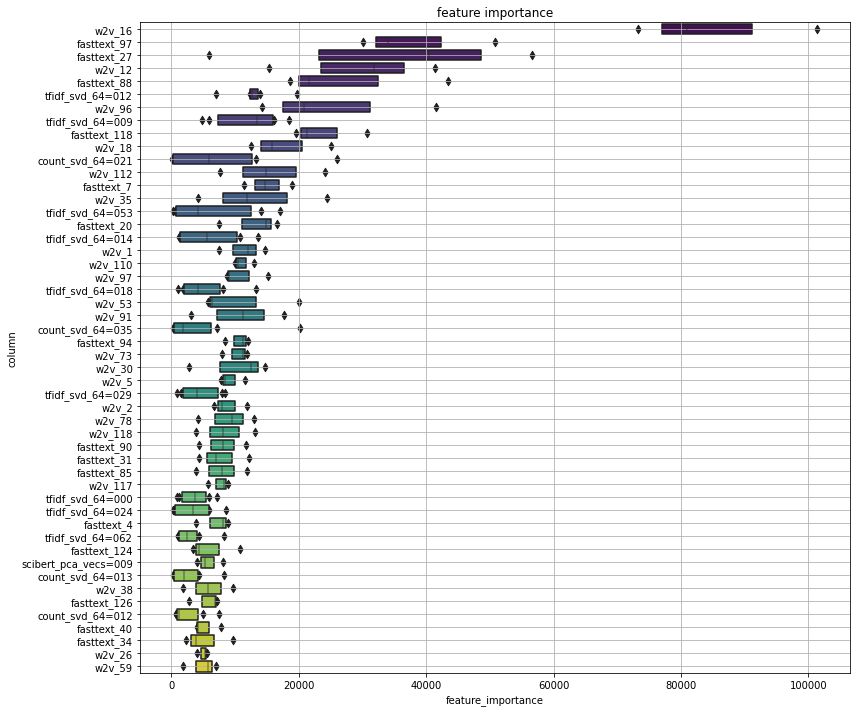

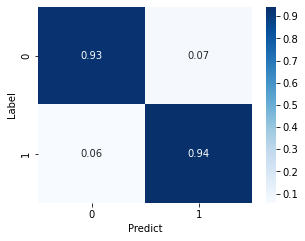

[2021-09-30 15:55:49] - lgb-2021_fold1 inference


# ============= # Inference # ============= #


[2021-09-30 15:55:55] - lgb-2021_fold2 inference
[2021-09-30 15:56:02] - lgb-2021_fold3 inference
[2021-09-30 15:56:08] - lgb-2021_fold4 inference
[2021-09-30 15:56:13] - lgb-2021_fold5 inference


In [32]:
if __name__ == "__main__":
    main()